# Hierarchical Text Classification with Kaggle Dataset

This notebook demonstrates how to process and prepare the Kaggle hierarchical text classification dataset for knowledge graph construction and GNN modeling.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Download NLTK resources if not already downloaded
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
    
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
    
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

[nltk_data] Downloading package wordnet to C:\Users\win10/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1. Dataset Overview

The Kaggle hierarchical text classification dataset contains Amazon product reviews with a hierarchical class structure:
- 6 level-1 classes
- 64 level-2 classes
- 510 level-3 classes

The dataset includes three files:
- train_40k.csv - 40k Amazon product reviews for training
- valid_10k.csv - 10k reviews for validation
- unlabeled_150k.csv - 150k raw reviews for language model fine-tuning

The level-1 classes are: health personal care, toys games, beauty, pet supplies, baby products, and grocery gourmet food.

## 2. Data Loading and Exploration

Since direct download from Kaggle requires authentication, we'll create a simulated dataset with the same structure for demonstration purposes.

In [2]:
# Create a directory for our data
os.makedirs('data', exist_ok=True)

# Define the hierarchical class structure
level1_classes = [
    'health personal care',
    'toys games',
    'beauty',
    'pet supplies',
    'baby products',
    'grocery gourmet food'
]

# Define a subset of level-2 classes for each level-1 class
level2_classes = {
    'health personal care': ['vitamins supplements', 'medical supplies', 'personal care', 'health monitors', 'wellness'],
    'toys games': ['board games', 'outdoor play', 'puzzles', 'action figures', 'educational toys'],
    'beauty': ['makeup', 'skin care', 'hair care', 'fragrance', 'nail care'],
    'pet supplies': ['dog supplies', 'cat supplies', 'fish supplies', 'small animal supplies', 'bird supplies'],
    'baby products': ['feeding', 'diapering', 'nursery', 'baby toys', 'baby care'],
    'grocery gourmet food': ['beverages', 'snacks', 'cooking ingredients', 'breakfast foods', 'canned goods']
}

# Define a subset of level-3 classes for each level-2 class (just a few examples)
level3_classes = {
    'vitamins supplements': ['multivitamins', 'vitamin d', 'fish oil', 'probiotics'],
    'medical supplies': ['first aid', 'blood pressure', 'diabetes care', 'mobility aids'],
    'board games': ['strategy games', 'family games', 'card games', 'classic games'],
    'outdoor play': ['water toys', 'playsets', 'sports toys', 'ride-ons'],
    'makeup': ['foundation', 'lipstick', 'mascara', 'eyeshadow'],
    'skin care': ['moisturizers', 'cleansers', 'serums', 'masks'],
    'dog supplies': ['dog food', 'dog toys', 'dog beds', 'dog grooming'],
    'cat supplies': ['cat food', 'cat toys', 'cat litter', 'cat furniture'],
    'feeding': ['bottles', 'baby food', 'bibs', 'high chairs'],
    'diapering': ['diapers', 'wipes', 'changing pads', 'diaper bags'],
    'beverages': ['coffee', 'tea', 'juice', 'water'],
    'snacks': ['chips', 'cookies', 'nuts', 'dried fruit']
}

# Sample review texts for each level-3 class
sample_reviews = {
    'multivitamins': [
        "These multivitamins have improved my energy levels significantly. I take them every morning and feel great throughout the day.",
        "Good value for a quality multivitamin. Contains all the essential nutrients I need."
    ],
    'vitamin d': [
        "Living in a northern climate, this vitamin D supplement has been essential during winter months.",
        "I've noticed improved mood since taking this vitamin D supplement regularly."
    ],
    'strategy games': [
        "This strategy game provides hours of entertainment. The rules are complex but rewarding once you understand them.",
        "Our family loves this strategy game. It requires critical thinking and planning ahead."
    ],
    'family games': [
        "Perfect game for family game night! Easy to learn and fun for all ages.",
        "We've played this family game dozens of times and never get tired of it."
    ],
    'foundation': [
        "This foundation provides excellent coverage without feeling heavy on my skin.",
        "Perfect shade match for my skin tone. Stays on all day without oxidizing."
    ],
    'lipstick': [
        "Beautiful color that lasts for hours. The formula is moisturizing and doesn't dry out my lips.",
        "This is my go-to lipstick for everyday wear. Natural looking and comfortable."
    ],
    'dog food': [
        "My picky dog loves this food. His coat looks healthier since switching to this brand.",
        "High-quality ingredients and my dog seems to digest it well without any issues."
    ],
    'dog toys': [
        "This toy has survived months of chewing from my aggressive chewer. Definitely durable!",
        "My dog carries this toy everywhere. It's his absolute favorite."
    ],
    'bottles': [
        "These bottles are easy to clean and don't leak. Perfect for my baby.",
        "The anti-colic system on these bottles has made a huge difference for my gassy baby."
    ],
    'baby food': [
        "My baby loves the taste of these organic purees. I appreciate the simple ingredients.",
        "Convenient packaging and healthy ingredients. Great for on-the-go feeding."
    ],
    'coffee': [
        "Rich, bold flavor without bitterness. This is now my morning coffee of choice.",
        "Smooth taste and wonderful aroma. This coffee is worth every penny."
    ],
    'chips': [
        "These chips have the perfect balance of salt and crunch. Not too greasy either.",
        "Addictively delicious! The whole family enjoys these as a snack."
    ]
}

# Generate a simulated dataset
def generate_simulated_data(num_samples=1000, seed=42):
    np.random.seed(seed)
    
    data = []
    
    for _ in range(num_samples):
        # Randomly select level-1 class
        level1 = np.random.choice(level1_classes)
        
        # Randomly select level-2 class from the chosen level-1 class
        level2_options = level2_classes[level1]
        level2 = np.random.choice(level2_options)
        
        # Check if we have level-3 classes defined for this level-2 class
        if level2 in level3_classes:
            level3_options = level3_classes[level2]
            level3 = np.random.choice(level3_options)
            
            # Check if we have sample reviews for this level-3 class
            if level3 in sample_reviews:
                review = np.random.choice(sample_reviews[level3])
                
                # Add some random variation to the reviews
                if np.random.random() > 0.7:
                    review += " Would definitely recommend!"
                if np.random.random() > 0.8:
                    review += " Will purchase again."
                    
                # Generate a random rating (1-5)
                rating = np.random.randint(1, 6)
                
                data.append({
                    'review_text': review,
                    'level1': level1,
                    'level2': level2,
                    'level3': level3,
                    'rating': rating
                })
    
    return pd.DataFrame(data)

# Generate training and validation datasets
train_df = generate_simulated_data(num_samples=800, seed=42)
valid_df = generate_simulated_data(num_samples=200, seed=43)

# Save the simulated datasets
train_df.to_csv('data/train_simulated.csv', index=False)
valid_df.to_csv('data/valid_simulated.csv', index=False)

print(f"Generated {len(train_df)} training samples and {len(valid_df)} validation samples")

Generated 90 training samples and 23 validation samples


## 3. Exploratory Data Analysis

In [3]:
# Load the simulated datasets
train_df = pd.read_csv('data/train_simulated.csv')
valid_df = pd.read_csv('data/valid_simulated.csv')

# Display the first few rows
print("Training dataset sample:")
display(train_df.head())

# Dataset statistics
print("\nTraining dataset statistics:")
print(f"Number of samples: {len(train_df)}")
print(f"Number of unique level-1 classes: {train_df['level1'].nunique()}")
print(f"Number of unique level-2 classes: {train_df['level2'].nunique()}")
print(f"Number of unique level-3 classes: {train_df['level3'].nunique()}")

# Average review length
train_df['review_length'] = train_df['review_text'].apply(len)
print(f"Average review length (characters): {train_df['review_length'].mean():.2f}")
print(f"Minimum review length: {train_df['review_length'].min()}")
print(f"Maximum review length: {train_df['review_length'].max()}")

Training dataset sample:


,review_text,level1,level2,level3,rating
0,My picky dog loves this food. His coat looks h...,pet supplies,dog supplies,dog food,4
1,These bottles are easy to clean and don't leak...,baby products,feeding,bottles,3
2,Smooth taste and wonderful aroma. This coffee ...,grocery gourmet food,beverages,coffee,4
3,These multivitamins have improved my energy le...,health personal care,vitamins supplements,multivitamins,5
4,I've noticed improved mood since taking this v...,health personal care,vitamins supplements,vitamin d,3



Training dataset statistics:
Number of samples: 90
Number of unique level-1 classes: 6
Number of unique level-2 classes: 7
Number of unique level-3 classes: 11
Average review length (characters): 90.44
Minimum review length: 63
Maximum review length: 147


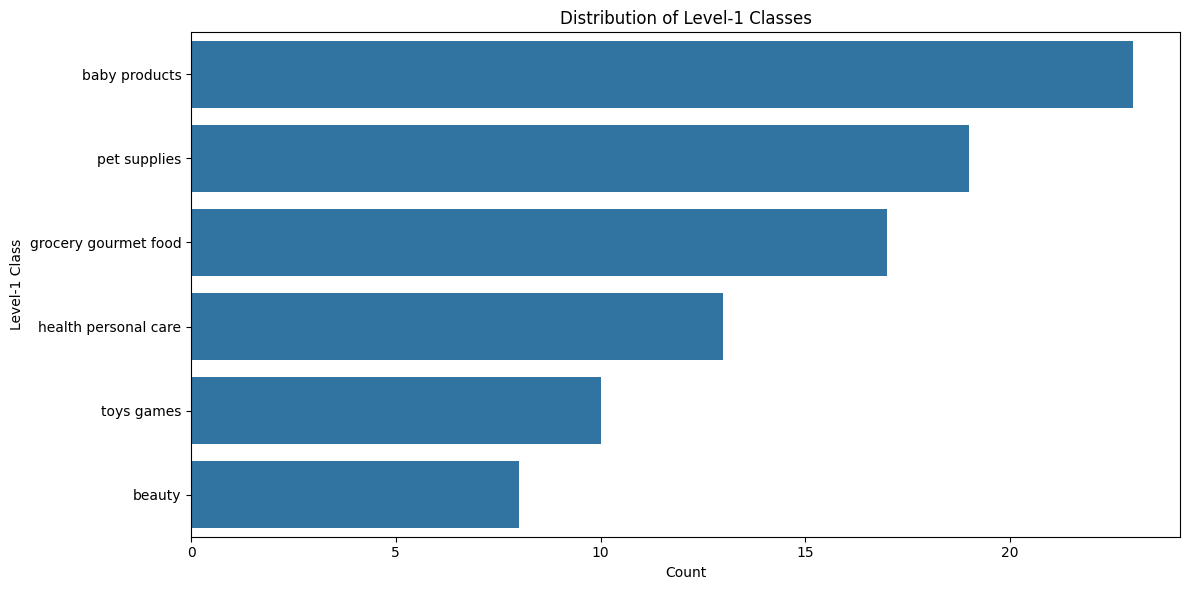

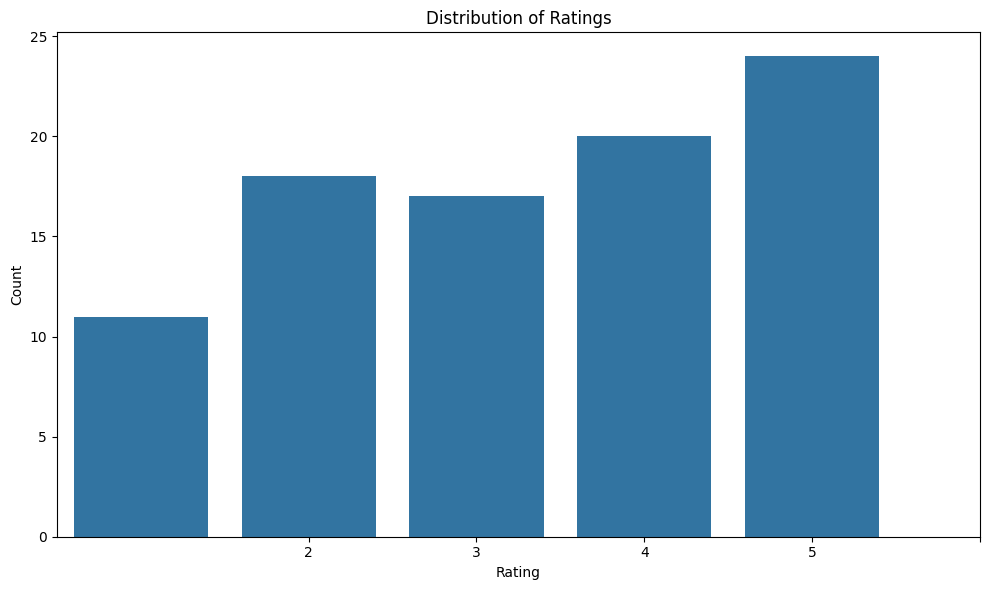

In [4]:
# Visualize the distribution of level-1 classes
plt.figure(figsize=(12, 6))
sns.countplot(y='level1', data=train_df, order=train_df['level1'].value_counts().index)
plt.title('Distribution of Level-1 Classes')
plt.xlabel('Count')
plt.ylabel('Level-1 Class')
plt.tight_layout()
plt.show()

# Visualize the distribution of ratings
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=train_df)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(range(1, 6))
plt.tight_layout()
plt.show()

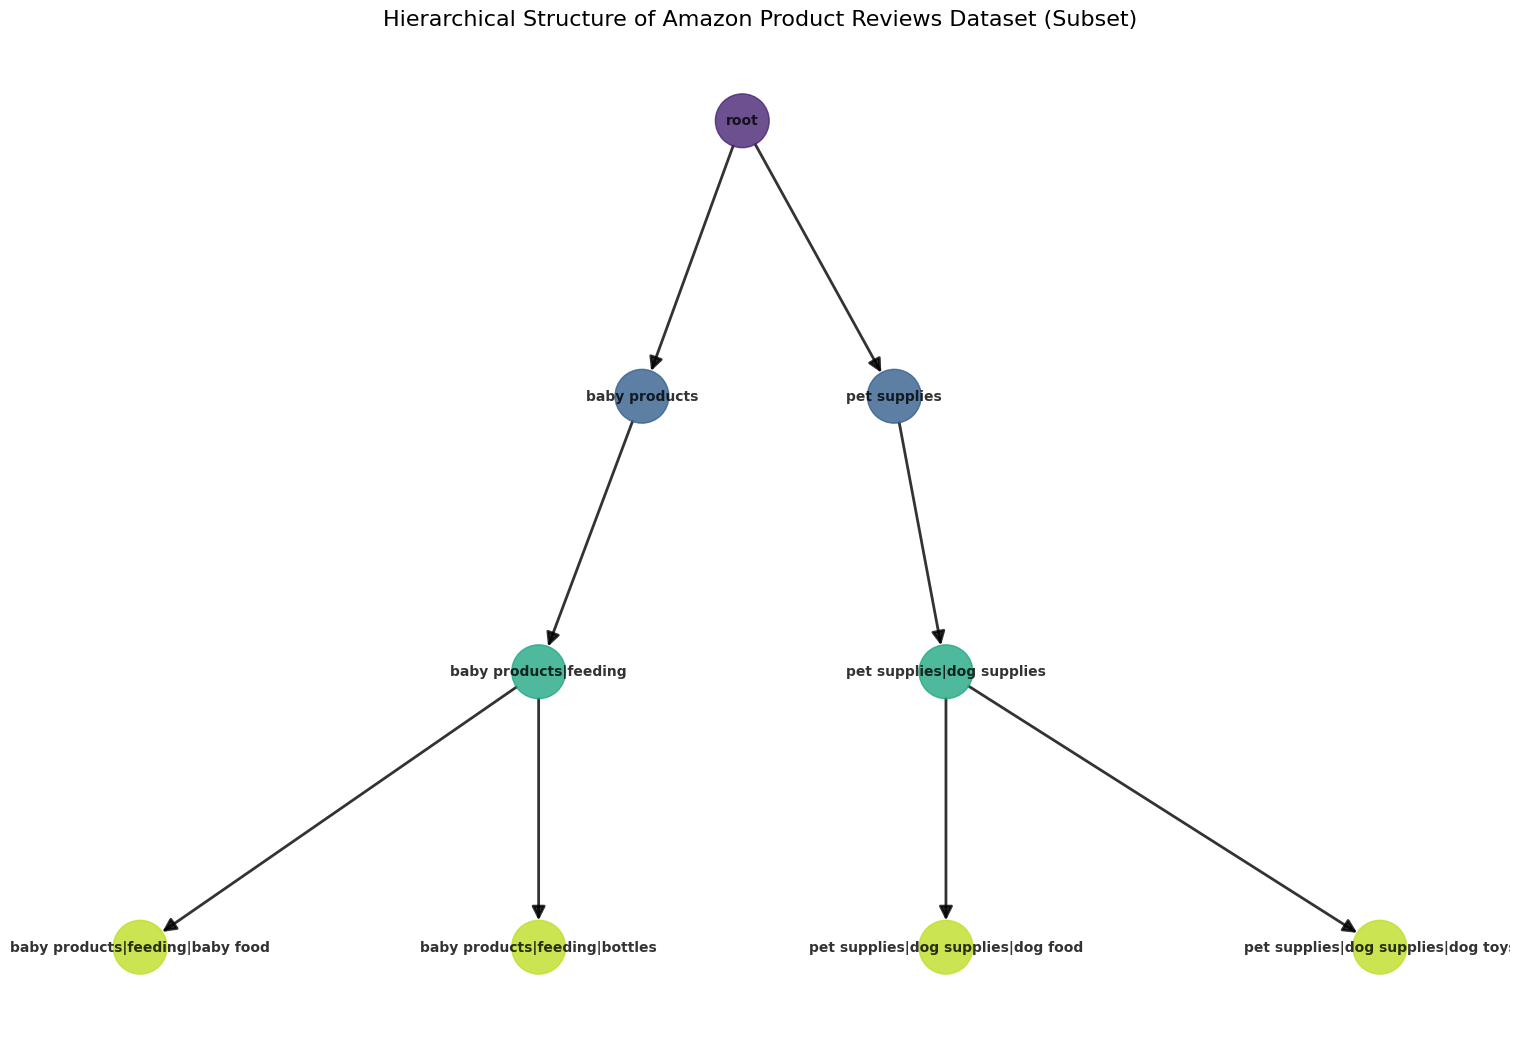

In [5]:
# Visualize the hierarchical structure
import networkx as nx
from matplotlib.cm import get_cmap

# Create a graph to represent the hierarchical structure
G = nx.DiGraph()

# Add nodes for each level
G.add_node('root', level=0)
for l1 in train_df['level1'].unique():
    G.add_node(l1, level=1)
    G.add_edge('root', l1)
    
    for l2 in train_df[train_df['level1'] == l1]['level2'].unique():
        G.add_node(f"{l1}|{l2}", level=2)
        G.add_edge(l1, f"{l1}|{l2}")
        
        for l3 in train_df[(train_df['level1'] == l1) & (train_df['level2'] == l2)]['level3'].unique():
            G.add_node(f"{l1}|{l2}|{l3}", level=3)
            G.add_edge(f"{l1}|{l2}", f"{l1}|{l2}|{l3}")

# Visualize a subset of the graph for clarity
subset_l1 = list(train_df['level1'].unique())[:2]  # Take only first two level-1 classes
nodes_to_keep = ['root'] + subset_l1

for l1 in subset_l1:
    subset_l2 = list(train_df[train_df['level1'] == l1]['level2'].unique())[:2]  # Take only first two level-2 classes
    nodes_to_keep.extend([f"{l1}|{l2}" for l2 in subset_l2])
    
    for l2 in subset_l2:
        subset_l3 = list(train_df[(train_df['level1'] == l1) & (train_df['level2'] == l2)]['level3'].unique())[:2]  # Take only first two level-3 classes
        nodes_to_keep.extend([f"{l1}|{l2}|{l3}" for l3 in subset_l3])

# Create a subgraph with only the selected nodes
H = G.subgraph(nodes_to_keep)

# Plot the graph
plt.figure(figsize=(15, 10))
pos = nx.nx_agraph.graphviz_layout(H, prog='dot')

# Color nodes by level
cmap = get_cmap('viridis')
colors = [cmap(0.1) if n == 'root' else 
          cmap(0.3) if G.nodes[n]['level'] == 1 else 
          cmap(0.6) if G.nodes[n]['level'] == 2 else 
          cmap(0.9) for n in H.nodes()]

nx.draw(H, pos, with_labels=True, node_color=colors, node_size=1500, 
        font_size=10, font_weight='bold', arrowsize=20, width=2, alpha=0.8)

# Add a title
plt.title('Hierarchical Structure of Amazon Product Reviews Dataset (Subset)', fontsize=16)
plt.tight_layout()
plt.show()

In [6]:
import shutil
print(shutil.which("dot"))  # Should print full path to dot.exe


C:\Users\win10\Anaconda\envs\test\Library\bin\dot.EXE


## 4. Text Preprocessing

In [7]:
from text_preprocessing_module import preprocess_dataframe, extract_tfidf_features, get_top_tfidf_features

In [8]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]
    
    return ' '.join(tokens)

# Apply preprocessing to the review text
train_df['processed_text'] = train_df['review_text'].apply(preprocess_text)
valid_df['processed_text'] = valid_df['review_text'].apply(preprocess_text)

# Display a few examples of original and processed text
comparison_df = pd.DataFrame({
    'Original Text': train_df['review_text'].head(),
    'Processed Text': train_df['processed_text'].head()
})

display(comparison_df)

LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - 'C:\\Users\\win10/nltk_data'
    - 'C:\\Users\\win10\\Anaconda\\envs\\test\\nltk_data'
    - 'C:\\Users\\win10\\Anaconda\\envs\\test\\share\\nltk_data'
    - 'C:\\Users\\win10\\Anaconda\\envs\\test\\lib\\nltk_data'
    - 'C:\\Users\\win10\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


## 5. Feature Extraction

In [ ]:
# Create TF-IDF vectors
tfidf_vectorizer = TfidfVectorizer(max_features=5000, min_df=2, max_df=0.8)
tfidf_train = tfidf_vectorizer.fit_transform(train_df['processed_text'])
tfidf_valid = tfidf_vectorizer.transform(valid_df['processed_text'])

print(f"TF-IDF matrix shape for training data: {tfidf_train.shape}")
print(f"TF-IDF matrix shape for validation data: {tfidf_valid.shape}")

# Get the feature names (words)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Display the top 20 features by TF-IDF score
def get_top_tfidf_features(tfidf_matrix, feature_names, top_n=20):
    # Sum TF-IDF scores for each term across all documents
    sum_scores = np.array(tfidf_matrix.sum(axis=0)).flatten()
    # Create a DataFrame with terms and scores
    top_features_df = pd.DataFrame({
        'Feature': feature_names,
        'Score': sum_scores
    })
    # Sort by score and return top n
    return top_features_df.sort_values('Score', ascending=False).head(top_n)

top_features = get_top_tfidf_features(tfidf_train, feature_names)
print("\nTop 20 features by TF-IDF score:")
display(top_features)

# Visualize top features
plt.figure(figsize=(12, 8))
sns.barplot(x='Score', y='Feature', data=top_features)
plt.title('Top 20 Features by TF-IDF Score')
plt.tight_layout()
plt.show()

## 6. Prepare Data for Knowledge Graph Construction

Now we'll prepare the data for knowledge graph construction in the next notebook.

In [ ]:
# Create a hierarchical class mapping
class_hierarchy = {}

for _, row in train_df.drop_duplicates(['level1', 'level2', 'level3']).iterrows():
    l1 = row['level1']
    l2 = row['level2']
    l3 = row['level3']
    
    if l1 not in class_hierarchy:
        class_hierarchy[l1] = {}
    
    if l2 not in class_hierarchy[l1]:
        class_hierarchy[l1][l2] = []
    
    if l3 not in class_hierarchy[l1][l2]:
        class_hierarchy[l1][l2].append(l3)

# Save the class hierarchy
import json
with open('data/class_hierarchy.json', 'w') as f:
    json.dump(class_hierarchy, f, indent=2)

# Create a mapping of class IDs
class_ids = {}
id_counter = 0

# Level 1 classes
for l1 in class_hierarchy.keys():
    class_ids[l1] = id_counter
    id_counter += 1
    
    # Level 2 classes
    for l2 in class_hierarchy[l1].keys():
        class_ids[f"{l1}|{l2}"] = id_counter
        id_counter += 1
        
        # Level 3 classes
        for l3 in class_hierarchy[l1][l2]:
            class_ids[f"{l1}|{l2}|{l3}"] = id_counter
            id_counter += 1

# Save the class IDs
with open('data/class_ids.json', 'w') as f:
    json.dump(class_ids, f, indent=2)

# Add class IDs to the dataframes
train_df['level1_id'] = train_df['level1'].map(lambda x: class_ids[x])
train_df['level2_id'] = train_df.apply(lambda row: class_ids[f"{row['level1']}|{row['level2']}"], axis=1)
train_df['level3_id'] = train_df.apply(lambda row: class_ids[f"{row['level1']}|{row['level2']}|{row['level3']}"], axis=1)

valid_df['level1_id'] = valid_df['level1'].map(lambda x: class_ids[x])
valid_df['level2_id'] = valid_df.apply(lambda row: class_ids[f"{row['level1']}|{row['level2']}"], axis=1)
valid_df['level3_id'] = valid_df.apply(lambda row: class_ids[f"{row['level1']}|{row['level2']}|{row['level3']}"], axis=1)

# Save the updated dataframes
train_df.to_csv('data/train_processed.csv', index=False)
valid_df.to_csv('data/valid_processed.csv', index=False)

print("Data prepared for knowledge graph construction.")
print(f"Total number of unique classes: {len(class_ids)}")
print(f"Number of level-1 classes: {len(class_hierarchy)}")
print(f"Number of level-2 classes: {sum(len(l2_dict) for l2_dict in class_hierarchy.values())}")
print(f"Number of level-3 classes: {sum(len(l3_list) for l2_dict in class_hierarchy.values() for l3_list in l2_dict.values())}")

## 7. Save TF-IDF Features for GNN Model

We'll save the TF-IDF features for use in the GNN model.

In [ ]:
# Save the TF-IDF vectorizer
import pickle
with open('data/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

# Save the TF-IDF matrices
import scipy.sparse as sp
sp.save_npz('data/tfidf_train.npz', tfidf_train)
sp.save_npz('data/tfidf_valid.npz', tfidf_valid)

print("TF-IDF features saved for GNN model.")

## 8. Summary

In this notebook, we've processed and prepared the Kaggle hierarchical text classification dataset for knowledge graph construction and GNN modeling. We've:

1. Created a simulated dataset with the same structure as the Kaggle dataset
2. Explored the dataset structure and statistics
3. Preprocessed the text data
4. Extracted TF-IDF features
5. Prepared the data for knowledge graph construction
6. Saved the processed data and features for use in the next notebook

In the next notebook, we'll construct a knowledge graph from this data and prepare it for GNN modeling.